In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
# !pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.2 MB/s eta 0:00:00
  Preparing metadata

In [ ]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [ ]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [ ]:
import random
random.seed(42)
galleries = ['animal','tree']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [ ]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
    # return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [ ]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [ ]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [ ]:
# !pip install transformers
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          # ctfidf_model=ctfidf_model,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [ ]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
# for i in lst:
#   print(i)

생성된 주제의 수: 99


In [ ]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [ ]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:01<00:00, 76.89it/s]


In [ ]:
# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail, linkage_function=linkage_function)

In [ ]:
bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
# 주제, 분기점 별 클러스터 구성 라벨 수
verify = True
table = [[0 for r in range(2)] for t in range(max([int(x) for x in hierarchical_topics['Parent_ID']]) + 1)]
if verify:
  for j in range(number_of_topics):
    for i in range(len(topics)):
      if topics[i]==j:
        table[j][real_labels[i]]+=1
  for j in range(number_of_topics, len(table)):
    row = hierarchical_topics[hierarchical_topics['Parent_ID'] == str(j)].iloc[0]
    left, right = int(row['Child_Left_ID']), int(row['Child_Right_ID'])
    for i in range(len(table[0])):
      table[j][i] += table[left][i] + table[right][i]

In [ ]:
df = hierarchical_topics
selected_topics_ids = set()
for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

In [ ]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

In [ ]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

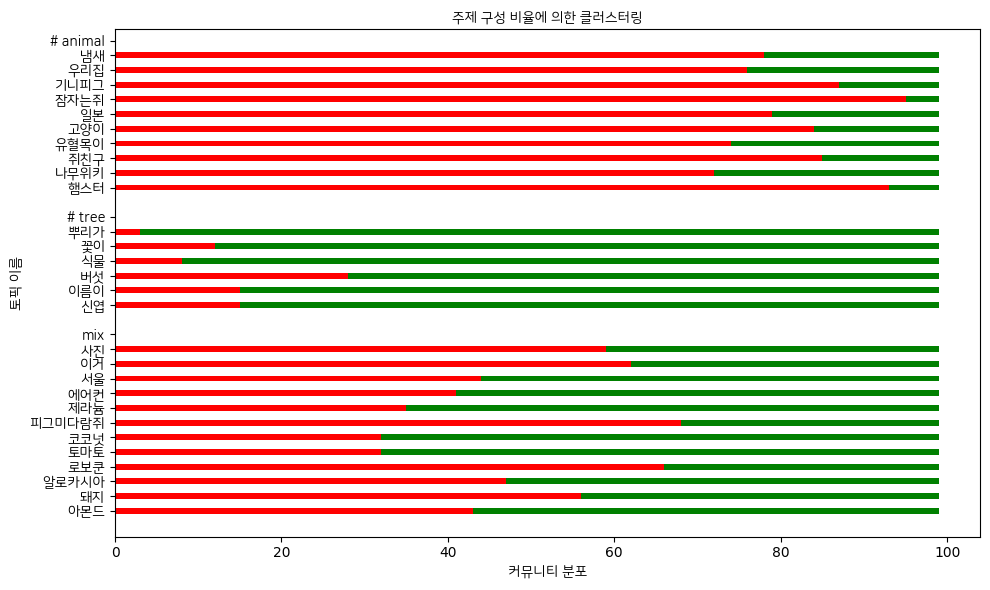

animal: ['냄새', '우리집', '기니피그', '잠자는쥐', '일본', '고양이', '유혈목이', '쥐친구', '나무위키', '햄스터'] - 5754
tree: ['뿌리가', '꽃이', '식물', '버섯', '이름이', '신엽'] - 7332
mix: ['사진', '이거', '서울', '에어컨', '제라늄', '피그미다람쥐', '코코넛', '토마토', '로보쿤', '알로카시아', '돼지', '아몬드'] - 5927


In [ ]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def clusterByRatio(th, table, selected_topics_ids, selected_topic_names, galleries, post_counts):
    selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
    for i in range(len(selected_topics_ids)):
        selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
        selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
    dic = dict()
    n_clusters = len(galleries) + 1
    clusters = [[] for _ in range(n_clusters)]
    name2idx = dict()
    for i in range(len(selected_topics_ids)):
        name2idx[selected_topic_names[i]] = int(selected_topics_ids[i])
        ratio = selected_topic_counts[i][0] / sum(selected_topic_counts[i])
        if ratio > (1 - th):
            clusters[0].append(selected_topic_names[i])
        elif ratio < th:
            clusters[1].append(selected_topic_names[i])
        else:
            clusters[2].append(selected_topic_names[i])
        dic[selected_topic_names[i]]=[ratio, 1-ratio, ]
    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for index, cluster in enumerate(clusters):
        y_positions.append(current_y)
        cluster_name ='# ' + galleries[index] if index<len(galleries) else 'mix'
        y_labels.append(cluster_name)
        for topic in cluster:
            current_y -= 1
            y_positions.append(current_y)
            y_labels.append(topic)
            ax.barh(current_y, int(dic[topic][0]*100), color='r', height=bar_width, label=topic)
            ax.barh(current_y, int(dic[topic][1]*100), color='g', left=int(dic[topic][0]*100), height=bar_width)
        current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("주제 구성 비율에 의한 클러스터링", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

    for idx, r in enumerate(clusters):
        name = galleries[idx] if idx < len(galleries) else 'mix'
        val = sum([sum(table[name2idx[x]]) for x in r])
        print(f'{name}: {r} - {val}')

    plt.show()
    return clusters

threshold = 0.3
cRatio =[]
if verify:
  cRatio = clusterByRatio(threshold, table, selected_topics_ids, selected_topic_names, galleries, post_counts)


In [ ]:
!pip install fasttext
import fasttext
from sklearn.cluster import KMeans
import numpy as np
from gensim import models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=2d1f659999994947c4daae6427e2e4765b91b35cfd6e75feff7e9a6997c15775
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
model_path = '/content/drive/MyDrive/jolnon/cc.ko.100.bin'
m_fasttext = models.fasttext.load_facebook_model(model_path)

ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa1\x9c'; replacing invalid characters, using '\\xed\\xa1\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb0\x80'; replacing invalid characters, using '\\xed\\xb0\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa7\x80'; replacing invalid characters, using '\\xed\\xa7\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb8\xb0'; replacing invalid characters, using '\\xed\\xb8\\xb0'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa0\x9c'; replacing invalid characters, using '\\xed\\xa0\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa6\xac'; replacing invalid characters, using '\\xed\\xa6\\xac'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb3\xb5'; replacing invalid characters, using '\\xed\\xb

In [ ]:
embeddings = [m_fasttext.wv[selected_topic_names[i]] for i in range(len(selected_topic_names))]
embed_ids = [selected_topics_ids[i] for i in range(len(selected_topic_names))]
embeddings = np.array(embeddings)

In [ ]:

for i in range(len(selected_topic_names)):
  print(selected_topic_names[i], selected_topics_ids[i])

냄새 168
뿌리가 140
사진 116
우리집 162
이거 131
기니피그 122
꽃이 112
서울 161
에어컨 128
제라늄 157
피그미다람쥐 169
잠자는쥐 156
코코넛 163
일본 130
식물 151
고양이 148
토마토 150
버섯 147
로보쿤 103
유혈목이 167
이름이 120
알로카시아 164
쥐친구 160
돼지 144
아몬드 145
나무위키 165
햄스터 158
신엽 152


In [ ]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
97,196,햄스터,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",194,식물,195,햄스터,1.470170
96,195,햄스터,"[0, 1, 3, 7, 8, 10, 11, 15, 16, 18, 19, 21, 23...",193,로보쿤,192,햄스터,1.276895
95,194,식물,"[2, 4, 5, 6, 9, 12, 13, 14, 17, 20, 22, 24, 26...",190,꽃이,120,이름이,1.252025
94,193,로보쿤,"[1, 16, 23, 27, 30, 36, 38, 41, 44, 45, 47, 54...",191,나무위키,103,로보쿤,1.116313
93,192,햄스터,"[0, 3, 7, 8, 10, 11, 15, 18, 19, 21, 25, 28, 2...",189,이거,158,햄스터,1.103140
...,...,...,...,...,...,...,...,...
4,103,로보쿤,"[1, 61]",1,로보쿤,61,로보쿤,0.797400
3,102,물을,"[5, 12]",12,잎이,5,물을,0.788258
2,101,햄스터,"[0, 18]",18,병원,0,햄스터,0.784769
1,100,꽃이,"[2, 4]",2,꽃이,4,신엽,0.685158


['뿌리가', '꽃이', '제라늄', '코코넛', '식물', '토마토', '알로카시아', '신엽', '버섯', '아몬드']
['기니피그', '피그미다람쥐', '잠자는쥐', '고양이', '유혈목이', '쥐친구', '돼지', '햄스터', '로보쿤']
['우리집', '냄새', '사진', '이거', '이름이', '에어컨', '서울', '일본', '나무위키']
{'name': 'Cluster #1', 'value': 8840, 'distribution': [17.782805429864254, 82.21719457013575], 'topics': [{'name': '뿌리가', 'value': 650, 'distribution': [3.8461538461538463, 96.15384615384616]}, {'name': '꽃이', 'value': 4066, 'distribution': [12.739793408755533, 87.26020659124447]}, {'name': '제라늄', 'value': 213, 'distribution': [35.2112676056338, 64.78873239436619]}, {'name': '코코넛', 'value': 1275, 'distribution': [32.31372549019608, 67.68627450980392]}, {'name': '식물', 'value': 1060, 'distribution': [8.20754716981132, 91.79245283018868]}, {'name': '토마토', 'value': 369, 'distribution': [32.24932249322493, 67.75067750677506]}, {'name': '알로카시아', 'value': 276, 'distribution': [47.10144927536232, 52.89855072463768]}, {'name': '신엽', 'value': 652, 'distribution': [15.644171779141104, 84.3558282208589]}

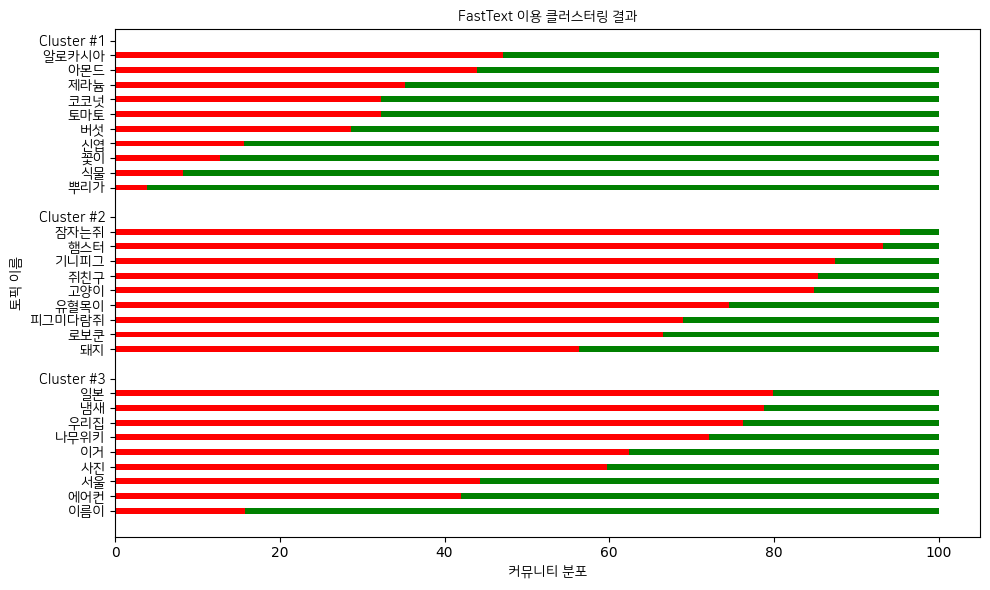

In [ ]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts):
  selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
  for i in range(len(selected_topics_ids)):
    selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
    selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
  dic = dict()
  n_clusters = len(galleries) + 1
  # clusters = [['뿌리가',	'꽃이',	'제라늄',	'코코넛',	'식물',	'토마토',	'알로카시아',	'신엽',	'버섯',	'아몬드'],
  #               ['기니피그',	'피그미다람쥐',	'잠자는쥐',	'고양이',	'유혈목이',	'쥐친구',	'돼지',	'햄스터',	'로보쿤'],
  #               ['우리집',	'냄새',	'사진',	'이거',	'이름이',	'에어컨',	'서울',	'일본',	'나무위키']]
  idx2name = dict(zip(selected_topics_ids,selected_topic_names))
  name2idx = dict(zip(selected_topic_names,selected_topics_ids))
  clustered_topics_name = [['뿌리가',	'꽃이',	'제라늄',	'코코넛',	'식물',	'토마토',	'알로카시아',	'신엽',	'버섯',	'아몬드'],
                ['기니피그',	'피그미다람쥐',	'잠자는쥐',	'고양이',	'유혈목이',	'쥐친구',	'돼지',	'햄스터',	'로보쿤'],
                ['우리집',	'냄새',	'사진',	'이거',	'이름이',	'에어컨',	'서울',	'일본',	'나무위키']]
  clustered_topics_count = [[] for _ in range(n_clusters)]
  clustered_topics = [[] for _ in range(n_clusters)]
  for i in range(len(clustered_topics_name)):
    for ele in clustered_topics_name[i]:
      clustered_topics[i].append(name2idx[ele])
  for r in clustered_topics_name:
    print(r)
  cluster_sums = []
  for idx, cluster in enumerate(clustered_topics):
    total_sum = 0
    for parent_id in cluster:
      row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
      topic_ids = row['Topics']
      cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
      clustered_topics_count[idx].append(cluster_sum)
      total_sum += cluster_sum
    cluster_sums.append(total_sum)
  if verify:
    clustered_count = [[0, 0] for _ in range(n_clusters)]
    for i in range(n_clusters):
      for j in clustered_topics[i]:
        clustered_count[i][0] += table[int(j)][0]
        clustered_count[i][1] += table[int(j)][1]

    for i in range(n_clusters):
      l, r = clustered_count[i][0], clustered_count[i][1]
      # print(f'Cluster #{i+1}: ({l + r}) - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
      for j in range(len(clustered_topics[i])):
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        # print(f'\t- {clustered_topics_name[i][j]} ({l + r}): [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
    clusters = []

    for i in range(n_clusters):
      cluster_info = {}
      l, r = clustered_count[i][0], clustered_count[i][1]
      cluster_info['name'] = f'Cluster #{i+1}'
      cluster_info['value'] = l + r
      cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

      topics_list = []
      for j in range(len(clustered_topics[i])):
        topic_info = {}
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        topic_info['name'] = clustered_topics_name[i][j]
        topic_info['value'] = l + r
        topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
        topics_list.append(topic_info)

      cluster_info['topics'] = topics_list
      clusters.append(cluster_info)

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    def sort_topics_by_distribution(cluster):
      cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

    for cluster in clusters:
      print(cluster)
      sort_topics_by_distribution(cluster)

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for cluster in clusters:
      y_positions.append(current_y)
      y_labels.append(cluster['name'])
      for topic in cluster['topics']:
        current_y -= 1
        y_positions.append(current_y)
        y_labels.append(topic['name'])
        ax.barh(current_y, topic['distribution'][0], color='r', height=bar_width, label=topic['name'])
        ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
      current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("FastText 이용 클러스터링 결과", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()
clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts)

In [ ]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


def showDistribution(n, verify, selected_topic_names, post_counts, embed_ids, hierarchical_topics, embeddings):
  n_clusters=n
  kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)

  clustered_topics = [[] for _ in range(n_clusters)]
  clustered_topics_name = [[] for _ in range(n_clusters)]
  clustered_topics_count = [[] for _ in range(n_clusters)]

  for i, label in enumerate(kmeans.labels_):
    clustered_topics[label].append(embed_ids[i])
    clustered_topics_name[label].append(selected_topic_names[i])
  for r in clustered_topics_name:
    print(r)

  cluster_sums = []
  for idx, cluster in enumerate(clustered_topics):
    total_sum = 0
    for parent_id in cluster:
      row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
      topic_ids = row['Topics']
      cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
      clustered_topics_count[idx].append(cluster_sum)
      total_sum += cluster_sum
    cluster_sums.append(total_sum)
  print(cluster_sums)
  if verify:
    clustered_count = [[0, 0] for _ in range(n_clusters)]
    for i in range(n_clusters):
      for j in clustered_topics[i]:
        clustered_count[i][0] += table[int(j)][0]
        clustered_count[i][1] += table[int(j)][1]

    for i in range(n_clusters):
      l, r = clustered_count[i][0], clustered_count[i][1]
      # print(f'Cluster #{i+1}: ({l + r}) - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
      for j in range(len(clustered_topics[i])):
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        # print(f'\t- {clustered_topics_name[i][j]} ({l + r}): [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
    clusters = []

    for i in range(n_clusters):
      cluster_info = {}
      l, r = clustered_count[i][0], clustered_count[i][1]
      cluster_info['name'] = f'Cluster #{i+1}'
      cluster_info['value'] = l + r
      cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

      topics_list = []
      for j in range(len(clustered_topics[i])):
        topic_info = {}
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        topic_info['name'] = clustered_topics_name[i][j]
        topic_info['value'] = l + r
        topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
        topics_list.append(topic_info)

      cluster_info['topics'] = topics_list
      clusters.append(cluster_info)

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    def sort_topics_by_distribution(cluster):
      cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

    for cluster in clusters:
      print(cluster)
      sort_topics_by_distribution(cluster)

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for cluster in clusters:
      y_positions.append(current_y)
      y_labels.append(cluster['name'])
      for topic in cluster['topics']:
        current_y -= 1
        y_positions.append(current_y)
        y_labels.append(topic['name'])
        ax.barh(current_y, topic['distribution'][0], color='r', height=bar_width, label=topic['name'])
        ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
      current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("FastText 이용 클러스터링 결과", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()
    return clustered_topics_name, clustered_topics_count, kmeans, clustered_topics

['꽃이']
['뿌리가', '사진', '우리집', '이거', '기니피그', '서울', '에어컨', '제라늄', '피그미다람쥐', '잠자는쥐', '코코넛', '일본', '고양이', '토마토', '로보쿤', '유혈목이', '이름이', '알로카시아', '쥐친구', '아몬드', '나무위키', '햄스터', '신엽']
['냄새', '식물', '버섯', '돼지']
[4066, 13195, 1752]
{'name': 'Cluster #1', 'value': 4066, 'distribution': [12.739793408755533, 87.26020659124447], 'topics': [{'name': '꽃이', 'value': 4066, 'distribution': [12.739793408755533, 87.26020659124447]}]}
{'name': 'Cluster #2', 'value': 13195, 'distribution': [59.94694960212202, 40.05305039787798], 'topics': [{'name': '뿌리가', 'value': 650, 'distribution': [3.8461538461538463, 96.15384615384616]}, {'name': '사진', 'value': 263, 'distribution': [59.6958174904943, 40.3041825095057]}, {'name': '우리집', 'value': 510, 'distribution': [76.27450980392157, 23.725490196078432]}, {'name': '이거', 'value': 1244, 'distribution': [62.37942122186495, 37.62057877813505]}, {'name': '기니피그', 'value': 183, 'distribution': [87.43169398907104, 12.568306010928962]}, {'name': '서울', 'value': 323, 'distribution': 

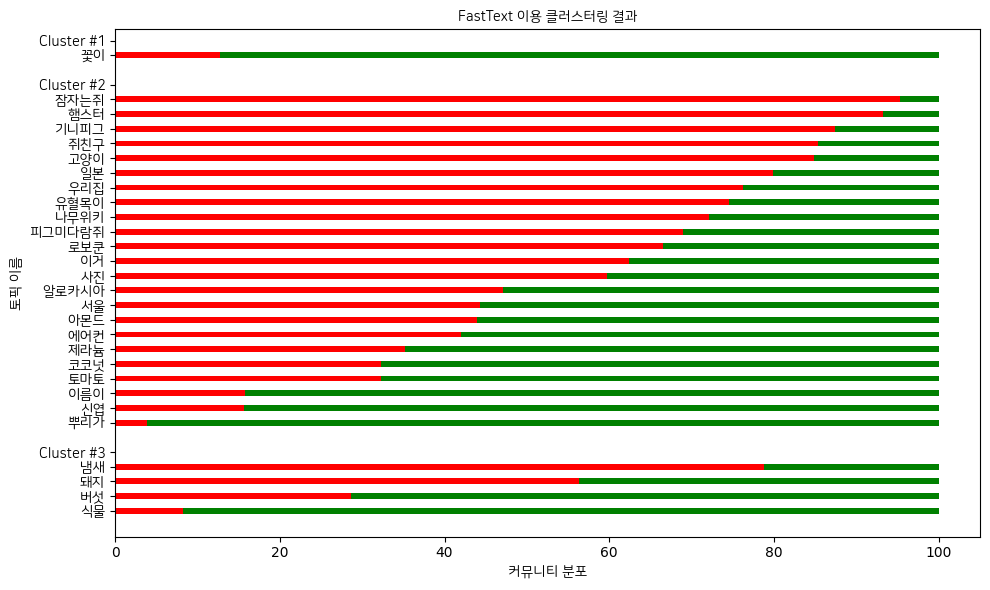

In [ ]:
clustered_topics_name, clustered_topics_count, kmeans, clustered_topics = showDistribution(3, verify, selected_topic_names, post_counts, embed_ids, hierarchical_topics, embeddings)

In [ ]:
for r in zip(clustered_topics_name, clustered_topics_count):
  print(r)

(['꽃이'], [4066])
(['뿌리가', '사진', '우리집', '이거', '기니피그', '서울', '에어컨', '제라늄', '피그미다람쥐', '잠자는쥐', '코코넛', '일본', '고양이', '토마토', '로보쿤', '유혈목이', '이름이', '알로카시아', '쥐친구', '아몬드', '나무위키', '햄스터', '신엽'], [650, 263, 510, 1244, 183, 323, 243, 213, 235, 148, 1275, 114, 575, 369, 1203, 173, 782, 276, 299, 157, 111, 3197, 652])
(['냄새', '식물', '버섯', '돼지'], [444, 1060, 122, 126])


In [ ]:
import fasttext
from sklearn.cluster import KMeans
import numpy as np

def find_similar_words(word_list, weights, model, top_n=1):
    vectors = [model.wv[word] for word in word_list]
    avg_vector = np.average(vectors, axis=0,weights=weights)
    # avg_vector = np.mean(vectors, axis=0)
    similar_words = model.wv.similar_by_vector(avg_vector)
    return [word[0] for word in similar_words]
n_clusters=3
for i in range(n_clusters):
  print(f'{find_similar_words(clustered_topics_name[i], clustered_topics_count[i], m_fasttext)[0]}: {sum(clustered_topics_count[i])}')


꽃이: 4066
햄스터: 13195
식물: 1752


In [ ]:
def show(cname):
  for i in range(3):
    print(sorted(cname[i]))

In [ ]:
show(cRatio)

['고양이', '기니피그', '나무위키', '냄새', '우리집', '유혈목이', '일본', '잠자는쥐', '쥐친구', '햄스터']
['꽃이', '버섯', '뿌리가', '식물', '신엽', '이름이']
['돼지', '로보쿤', '사진', '서울', '아몬드', '알로카시아', '에어컨', '이거', '제라늄', '코코넛', '토마토', '피그미다람쥐']


In [ ]:
show(clustered_topics_name)

['꽃이']
['고양이', '기니피그', '나무위키', '로보쿤', '뿌리가', '사진', '서울', '신엽', '아몬드', '알로카시아', '에어컨', '우리집', '유혈목이', '이거', '이름이', '일본', '잠자는쥐', '제라늄', '쥐친구', '코코넛', '토마토', '피그미다람쥐', '햄스터']
['냄새', '돼지', '버섯', '식물']
